In [1]:
from community import community_louvain
import gc
import logging
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from scipy.optimize import differential_evolution, basinhopping
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_probability as tfp
import warnings
logger = tf.get_logger()

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
logging.basicConfig(encoding='utf-8', level=logging.DEBUG,
                    force = True)

In [3]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [4]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(i, j)
                G.add_edge(j, i)
    return G

In [35]:
def clip(l,r,x):
    return max(l,min(r,x))

def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c),dtype= 'float64')
    for i in range(n):
        W[i][i] = 1
    j = n
    for edge in G.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    for edge in C.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-1/2 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_theta(G):
    n = len(G.nodes())
    max_degree = max([G.degree(i) for i in range(n)])
#     logging.debug("Max degree = {}".format(max_degree))
    if max_degree == 0:
        return np.array([1 for i in range(n)])
    return np.array([clip(0,1,1 - G.degree(i)/max_degree + random.random()/1000) for i in range(n)])  # Works bad for small graphs
#     return np.array([random.random() for i in range(n)])

def build_network(G):
    logging.info("Build network on graph G:{}.".format(str(G)))
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    theta = build_theta(G)
#     logging.debug("Initial theta = {}".format(theta))
    return (W,b,w, theta, C)


In [50]:
def get_result_nodes(theta, alpha = 0.5):
    return set(np.argwhere(theta > alpha).reshape(-1))

def not_connected_nodes_exist_in_G(G, result_nodes):
    for v in G.nodes():
        if v not in result_nodes:
            node_not_connected_to_G = True
            for edge in G.neighbors(v):
                if edge in result_nodes:
                    node_not_connected_to_G = False
                    break
            if node_not_connected_to_G:
                return True
    return False
            
def graph_has_no_edges(G, result_nodes):
    for v in result_nodes:
        for edge in G.neighbors(v):
            if edge in result_nodes:
                return False
    return True
            
def result_is_valid(G, theta):
    result_nodes = get_result_nodes(theta)
    return graph_has_no_edges(G, result_nodes) and not not_connected_nodes_exist_in_G(G, result_nodes)
    
def network(theta,e_n,W_t,h,b,w_t):
#         h = tf.sigmoid(theta) # To make variable be from 0 to 1
        h = tf.math.multiply(e_n,theta)
        h = tf.linalg.matvec(W_t,h)
        h = tf.add(h,b)
        h = tf.nn.relu(h)
        h = tf.tensordot(w_t,h, 1)
        return h.numpy()

def loss(theta,e_n,W_t,b,w_t):
    h = network(theta,e_n,W_t,h,b,w_t)
    return (h-h_d)**2    

def train_network(G, max_epochs = 100):
    (W,b,w, theta, C) = build_network(G)
    previous_theta = theta
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float64')
    b = tf.constant(b, dtype = 'float64')
    w_t = tf.constant(w.T, dtype = 'float64')
    theta = tf.Variable(theta,
                        trainable=True,
                        constraint = lambda x: tf.clip_by_value(theta,0,1),
                        dtype = 'float64')
    e_n = tf.constant(np.ones((n)),dtype = 'float64')

    
    

    h_d = -n*n/2
#     optimizer=tf.optimizers.Adam(learning_rate=0.1,)
    
#     epoch = 0
#     while not result_is_valid(G, theta) and epoch < max_epochs:
#         logging.debug("Epoch = {}".format(epoch))
#         optimizer.minimize(loss, var_list=[theta])
#         logging.debug("theta = {}".format(theta))
#         previous_error = loss()
# #         logging.debug("Loss = {}".format(previous_error))
#         epoch+=1
#         if (previous_theta == theta.numpy()).all():
#             logging.debug("Solver stuck")
#             break
#         previous_theta = theta.numpy()
    bounds = [(0,1) for i in range(n)]
    theta = differential_evolution(loss, bounds, x0 = theta, args = (e_n,W_t,b,w_t), workers = -1)
    print(theta)
    theta = theta.x
    if result_is_valid(G, theta):
        logging.debug("Optimal solution found. Cardinality = {}".format(len(get_result_nodes(theta))))
    return theta


In [51]:
def graphSets(graph): # Determinative algorithm to use correctness of the solution. Works too long for graphs >= 30 nodes.
      
    # Base Case - Given Graph 
    # has no nodes
    if(len(graph) == 0):
        return []
     
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
      
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
      
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
      
    # Delete current vertex 
    # from the Graph
    del graph2[vCurrent]
      
    # Recursive call - Gets 
    # Maximal Set,
    # assuming current Vertex 
    # not selected
    res1 = graphSets(graph2)
      
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
  
    # Loop through its neighbours
    for v in graph[vCurrent]:
          
        # Delete neighbor from 
        # the current subgraph
        if(v in graph2):
            del graph2[v]
      
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
      
    # Our final result is the one 
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2

def calculate_recursive_broot_force_result(G, draw_graph = True):
    dict_G = nx.to_dict_of_lists(G)
    print("Recursive approach")
    MIS = graphSets(dict_G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['red' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [52]:
def calculate_determenistic_result(G, draw_graph = True):
    print("Deterministic built-in approach")
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['yellow' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [53]:
def calculate_DNN_result(G, theta, threshold = 0.5, draw_graph = True):
    print("DNN approach")
    result_nodes = get_result_nodes(theta)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    if draw_graph:
        color_map = ['green' if node in result_nodes else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [32]:
def compareResults(G, max_epochs = 100, draw_graph = False):
#     calculate_recursive_broot_force_result(G)
    theta = train_network(G, max_epochs)
#     calculate_determenistic_result(G, draw_graph)
    calculate_DNN_result(G, theta, draw_graph=draw_graph)

In [33]:
def read_G_from_file(filepath):
    return nx.read_edgelist(filepath)

INFO:root:Build network on graph G:Graph with 8 nodes and 12 edges.
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


     fun: 576.0
     jac: array([1103.99998903, -192.00000355, -192.00000355, 1103.99998903,
       1103.99998903, -192.00000355, -192.00000355, 1103.99998903])
 message: 'Optimization terminated successfully.'
    nfev: 9957
     nit: 81
 success: True
       x: array([0., 1., 1., 0., 0., 1., 1., 0.])
DNN approach
{1, 2, 5, 6}
Length = 4


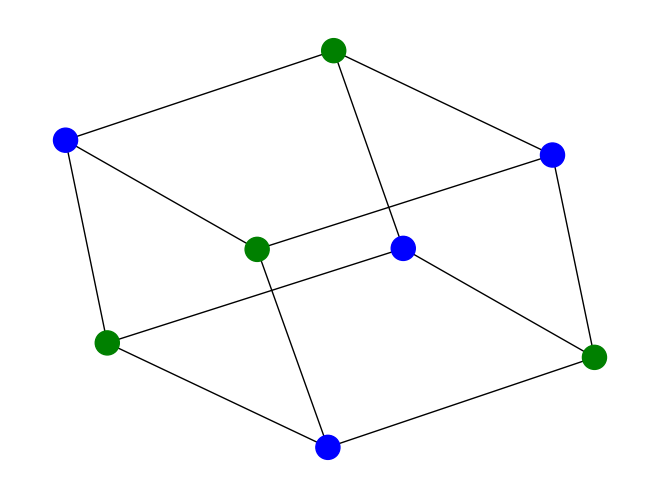

In [34]:
compareResults(build_test_graph1(), 100, True)

In [13]:
# compareResults(nx.complete_graph(10), draw_graph=False) # Expected result = 1

INFO:root:Build network on graph G:Graph named 'G1000' with 7 nodes and 12 edges.
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


     fun: 400.0
     jac: array([ 520.00000323, -119.99999796,  840.00000129, -119.99999796,
        840.00000129, -119.99999796,  520.00000323])
 message: 'Optimization terminated successfully.'
    nfev: 7251
     nit: 66
 success: True
       x: array([0., 1., 0., 1., 0., 1., 0.])
DNN approach
{1, 3, 5}
Length = 3


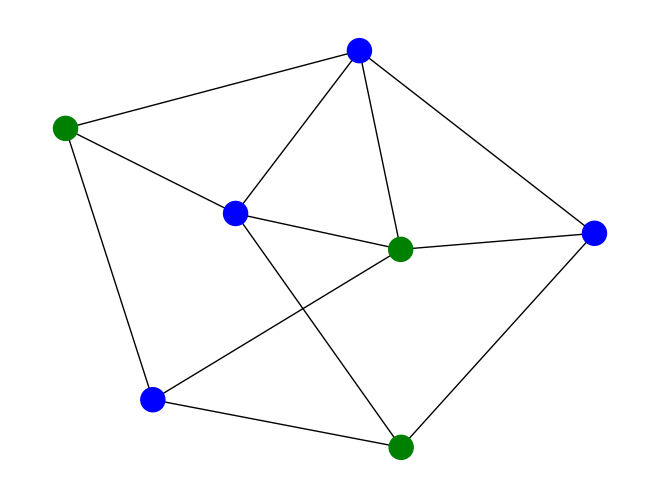

In [40]:
compareResults(nx.graph_atlas(1000),draw_graph=True)

INFO:root:Build network on graph G:Graph with 20 nodes and 17 edges.
DEBUG:root:Optimal solution found. Cardinality = 13
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


     fun: 13450.788505356039
     jac: array([ 2319.55073104,  7190.60735719, -3479.32617003, -3479.32617003,
        1443.85630121,  7190.60699339,  7190.60699339,  1391.73061353,
        1675.81092771,  7190.60699339, -3479.32617003, -3479.32617003,
       -3479.32562434, -3479.32562434, -3479.32562434, -3479.32526054,
       -3479.32526054, -3479.32526054, -3479.32526054,  2087.59702183])
 message: 'Optimization terminated successfully.'
    nfev: 82791
     nit: 270
 success: True
       x: array([0.        , 0.        , 1.        , 1.        , 0.67032175,
       0.        , 0.        , 0.95143095, 0.32967825, 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.04880783])
DNN approach
{2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18}
Length = 13


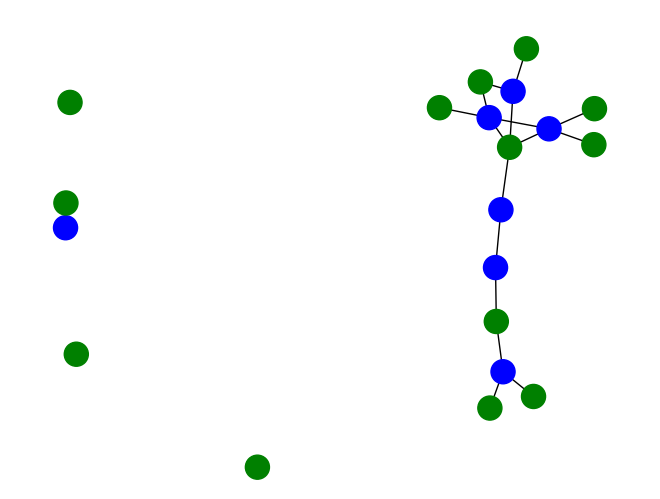

In [39]:
# compareResults(nx.gnp_random_graph(20, 0.1), 200, True) #Expected result around 12-14

In [16]:
# compareResults(nx.gnp_random_graph(50, 0.075), max_epochs = 1000)

In [17]:
# compareResults(nx.gnp_random_graph(100, 0.1), max_epochs = 1000, draw_graph=False)

In [67]:
wiki_vote_G = read_G_from_file('datasets/Wiki-Vote.txt') 

In [68]:
print(wiki_vote_G)

Graph with 7115 nodes and 100762 edges


In [14]:
def find_inter_cluster_edges(G, communities):
    edges = dict()
    for com in communities:
        for node_i in communities[com]:
            for neighbour_i in G.neighbors(node_i):
                if neighbour_i not in communities[com]:
                    if edges.get(node_i) is not None:
                        edges[node_i].append(neighbour_i)
                    else:
                        edges[node_i] = [neighbour_i]
                    if edges.get(neighbour_i) is not None:
                        edges[neighbour_i].append(node_i)
                    else:
                        edges[neighbour_i] = [node_i]
    return edges

def find_forbidden_edges(G, R, independent_sets):
    forbidden = []
    for node, edges in R.items():
        if node in independent_sets:
            for edge in edges:
                if edge in independent_sets:
                    forbidden.append((node, edge))
    return forbidden

def collect_list_by_dicts_key(partitions):
    communities = {}
    for key, val in partitions.items():
        if communities.get(val) == None:
            communities[val] = [key]
        else:
            communities[val].append(key)
    return communities

def build_G_from_nodes(G, nodes):
    communities = {}
    N = len(nodes)
    new_G = nx.Graph()
    index_map = dict()
    node_map = dict()
    index = 0
    for node in nodes:
        index_map[index] = node
        node_map[node] = index
        new_G.add_node(index)
        index+=1

    for i in nodes:
        for j in nodes:
            if G.has_edge(i,j):
                new_G.add_edge(node_map[i], node_map[j])
                new_G.add_edge(node_map[j], node_map[i])
    return (new_G, index_map, node_map)

In [15]:
def node_is_new_candidate(G, node, mis):
    neighbors = G.neighbors(node)
    neighbours_in_mis_count = 0
    for w in neighbors:
        if w in mis:
            neighbours_in_mis_count += 1
            if neighbours_in_mis_count == 2:
                break
            if neighbours_in_mis_count == 1:
                return (True, w)
    return (False, -1) 

def get_node_with_most_occurences(F, q, v):
    count_q = 0
    count_v = 0
    for x,y in F:
        if x == q:
            count_q+=1
        if y == v:
            count_v+=1
    if count_q > v:
        return q
    else:
        return v
            
def replace_node_if_possible(G,F,mis,node):
    if node not in mis:
        return True
    (can_be_replaced, new_node) = node_is_new_candidate(G,node,mis)
    if can_be_replaced:
        mis.remove(node)
        mis.add(new_node)
        return True
    return False 
        
def replace_forbiden_nodes(G,R,F,mis):
    logging.info("Replacing forbiden nodes")
    while len(F) > 0:
        logging.debug("Length of F = {}".format(len(F)))
        for q,v in F:
            replaced = replace_node_if_possible(G,F,mis,q)
            if replaced:
                break
            else:
                replaced = replace_node_if_possible(G,F,mis,v)
            if replaced:
                break
            else:
                node_to_be_removed = get_node_with_most_occurences(F,q,v)
                mis.remove(node_to_be_removed)
        F = find_forbidden_edges(G, R, mis)
    return mis

def build_G_from_left_nodes(G, mis):
    mis_with_neighbours = set()
    for node in mis:
        mis_with_neighbours.add(node)
        for neighbour in G.neighbors(node):
            mis_with_neighbours.add(neighbour)
    nodes_left_to_process = set(G.nodes()).difference(mis_with_neighbours)
    return build_G_from_nodes(G,nodes_left_to_process)

def calculate_mis_with_left_nodes(G, mis_list, max_epochs):
    (left_G, left_index_map, left_node_map)  = build_G_from_left_nodes(G, mis_list)
    logging.info("Left nodes size = {}".format(len(left_G.nodes())))
    if len(left_G.nodes()) > 1000:
        mis = calculate_large_G(left_G, max_epochs)
    else:
        mis = get_result_nodes(train_network(left_G, max_epochs))
    mis_correct = [left_index_map[node] for node in mis]
    mis_final = mis_list.union(mis)
    return mis_final

In [16]:
def calculate_large_G(G, max_epochs = 1000):
    gc.collect()
    partitions = community_louvain.best_partition(G, resolution= 0.8)
    communities = collect_list_by_dicts_key(partitions)
    logging.info("Total communities {}".format(len(communities)))
    R = find_inter_cluster_edges(G, communities)
    mis_list = set()
    community_index = 1
    for com in communities:
        logging.info("Community {} processing...".format(community_index))
        (small_G,index_map, node_map) = build_G_from_nodes(G, communities[com])
        theta_for_small_G = train_network(small_G, max_epochs)
        mis = get_result_nodes(theta_for_small_G)
        mis_correct = [index_map[node] for node in mis]
        mis_list = mis_list.union(mis_correct)
        community_index += 1
    F = find_forbidden_edges(G, R, mis_list)
    replace_forbiden_nodes(G,R,F,mis_list)
    return calculate_mis_with_left_nodes(G, mis_list, max_epochs)

In [17]:
wiki_vote_G_MIS = calculate_large_G(wiki_vote_G, 1000)

NameError: name 'wiki_vote_G' is not defined

In [41]:
def test_average_result_on_graph(G, graph_name, iterations = 10):
    sum = 0
    for i in range(iterations):
        mis = calculate_large_G(G, 50)
        sum+=len(mis)
    print("dNN result on {} = {}".format(graph_name,sum/iterations))

In [37]:
test_average_result_on_graph(nx.erdos_renyi_graph(100,0.1),"ER 100, 0.1")

INFO:root:Total communities 11
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 23 edges.
DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 16 edges.


     fun: 2304.0
     jac: array([4128.00000049, -479.99996909, -479.99996909, -479.99996909,
       -479.99996909, 4128.00000049, 1823.99994628, 1823.99994628,
       1823.99994628, -479.99996909, 2975.99999612])
 message: 'Optimization terminated successfully.'
    nfev: 14979
     nit: 82
 success: True
       x: array([0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 25 edges.


     fun: 2162.250006815748
     jac: array([1860.00002032, -650.99997883,  743.99999903, 2975.99999612,
        743.99999903,  130.84713835,  336.97715311, -650.99997883,
        -72.86998884, -651.0000243 , -651.0000243 ])
 message: 'Optimization terminated successfully.'
    nfev: 17388
     nit: 87
 success: True
       x: array([0.        , 1.        , 0.        , 0.        , 0.        ,
       0.49999999, 0.50000001, 1.        , 0.49999998, 1.        ,
       1.        ])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 18 edges.


     fun: 2757.819169546811
     jac: array([-503.79221395, -105.02990335, 1155.32875498, 1155.32875498,
       1155.32875498,  840.2390904 , -525.1493777 ,  -83.67269402,
       -735.20918335,  735.2092743 , 1155.32875498])
 message: 'Optimization terminated successfully.'
    nfev: 17118
     nit: 93
 success: True
       x: array([9.99752746e-01, 2.31341804e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.13372753e-02, 9.99467664e-01, 2.47244545e-04,
       1.00000000e+00, 9.88689254e-01, 0.00000000e+00])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 12 edges.


     fun: 1792.7938653504912
 message: 'Optimization terminated successfully.'
    nfev: 9587
     nit: 58
 success: True
       x: array([0.9893005 , 0.00926816, 0.01602138, 0.00693659, 0.98575627,
       0.99105706, 0.00699291, 0.00485986, 0.01325761, 0.98555309])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 17 edges.


     fun: 400.0
     jac: array([-119.99999796, -119.99999796, -119.99999796,  200.00000518,
        520.00000323,  840.00000129,  520.00000323])
 message: 'Optimization terminated successfully.'
    nfev: 10448
     nit: 95
 success: True
       x: array([1., 1., 1., 0., 0., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 22 edges.


     fun: 1409.1600119073105
     jac: array([ 600.62047851, 1426.47365919, 1426.47365919, -450.46535662,
        -48.78265827, 2252.32683988, -450.46540209, -198.93779963,
       -450.46535662, -375.38777444])
 message: 'Optimization terminated successfully.'
    nfev: 14434
     nit: 92
 success: True
       x: array([0.        , 0.        , 0.        , 1.        , 0.00524535,
       0.        , 1.        , 0.99475464, 1.        , 0.99434213])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 19 edges.


     fun: 3369.1040954328337
     jac: array([-812.6157768 , 1044.79172478, -580.4397886 , -812.61586775,
       2553.93538282, -812.61586775, -812.61586775, -464.35179708,
       4063.07890444, 2553.93538282, -464.35188803, 1044.79172478])
 message: 'Optimization terminated successfully.'
    nfev: 17047
     nit: 88
 success: True
       x: array([1.        , 0.        , 0.51427359, 1.        , 0.        ,
       1.        , 1.        , 0.48572639, 0.        , 0.        ,
       0.48543559, 0.        ])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 9 edges.


     fun: 2775.6775899258632
     jac: array([1159.06341307,  -17.46329872, -421.47753236, 1159.06341307,
       1159.06341307, 1053.69399535, -842.95520114,  526.8470405 ,
       -105.36941772, -333.57150474, -316.10816239])
 message: 'Optimization terminated successfully.'
    nfev: 15351
     nit: 86
 success: True
       x: array([0.00000000e+00, 8.61814284e-04, 8.32299269e-01, 0.00000000e+00,
       0.00000000e+00, 6.05657033e-05, 1.00000000e+00, 9.99996344e-01,
       2.11332708e-06, 9.99138177e-01, 1.63091300e-01])


DEBUG:root:Optimal solution found. Cardinality = 2
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 5 edges.


     fun: 256.0
     jac: array([160.00000187, 160.00000187, 160.00000187, -64.00000497,
       383.99999767, -64.00000497])
 message: 'Optimization terminated successfully.'
    nfev: 4730
     nit: 43
 success: True
       x: array([0., 0., 0., 1., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 2
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 12 edges.


     fun: 36.0
     jac: array([-23.99999973,  96.00000013, -23.99999973,  96.00000013])
 message: 'Optimization terminated successfully.'
    nfev: 2240
     nit: 35
 success: True
       x: array([1., 0., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 204
DEBUG:root:Length of F = 200
DEBUG:root:Length of F = 196
DEBUG:root:Length of F = 184
DEBUG:root:Length of F = 168
DEBUG:root:Length of F = 160
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 136
DEBUG:root:Length of F = 132
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 19
INFO:root:Build network on graph G:Graph with 19 nodes and 19 edges.


     fun: 400.0
     jac: array([ 520.00000323,  520.00000323,  520.00000323, -119.99999796,
       -119.99999796, -119.99999796,  840.00000129])
 message: 'Optimization terminated successfully.'
    nfev: 6137
     nit: 56
 success: True
       x: array([0., 0., 0., 1., 1., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 10
INFO:root:Total communities 10
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 9 edges.


     fun: 17030.25
     jac: array([18269.99978221,  2609.99986494, -2610.00057943, -2610.00057943,
       -2610.00057943, -2609.99985183, -2609.99985183,  2609.99986494,
       13050.00005232,  2609.99986494, -2610.00057943,  2609.99986494,
       -2610.00057943, -2610.00057943, -2610.00057943, -2610.00057943,
        7829.99959483,  7830.00032243,  2609.99986494])
 message: 'Optimization terminated successfully.'
    nfev: 79555
     nit: 274
 success: True
       x: array([0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 27 edges.


     fun: 182.25
     jac: array([-80.99999564, 296.99999686, -80.99999564, 485.999999  ,
       -80.99999564, 485.999999  ])
 message: 'Optimization terminated successfully.'
    nfev: 4958
     nit: 53
 success: True
       x: array([1., 0., 1., 0., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 36 edges.


     fun: 5184.0
     jac: array([3311.99998982, -719.9999309 , 3311.99998982, -719.9999309 ,
       -719.9999309 , 3311.99998982, 3311.99998982, 3311.99998982,
       7343.99991416, -719.9999309 , 3311.99998982, 3311.99998982,
       -719.9999309 ])
 message: 'Optimization terminated successfully.'
    nfev: 23588
     nit: 113
 success: True
       x: array([0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 22 edges.


     fun: 8941.07787058821
     jac: array([ 5106.09279445, -1323.80190979,  5106.09279445,   389.54767654,
        8131.92546048, -1323.80190979, -1323.80209169,  5106.09279445,
         200.43334998,  8131.92546048,  5106.09279445,  5106.09279445,
       -1323.80209169, -1323.80209169,  2080.26012842])
 message: 'Optimization terminated successfully.'
    nfev: 31896
     nit: 135
 success: True
       x: array([0.        , 1.        , 0.        , 0.05727293, 0.        ,
       1.        , 1.        , 0.        , 0.94272706, 0.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 21 edges.


     fun: 4424.302247636019
     jac: array([ -532.12352241,  5055.17245983,  1064.24677198,  -532.12352241,
        -931.21615906,  1330.30853249,   931.21597716,  3192.74049616,
        3192.74049616, -1197.27755499, -1197.27755499, -1197.27755499,
       -1197.27755499])
 message: 'Optimization terminated successfully.'
    nfev: 24091
     nit: 114
 success: True
       x: array([0.32769168, 0.        , 0.34311993, 0.32769168, 0.67230827,
       0.        , 0.65688008, 0.        , 0.        , 1.        ,
       1.        , 1.        , 1.        ])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 31 edges.


     fun: 2770.7748850325092
     jac: array([-736.93408552,  -10.92930688, -842.21041593, -105.27633094,
       1158.03923109, 1158.03923109,  736.93408552, 1158.03923109,
       -326.75820712, -210.55261637,  842.2104206 ])
 message: 'Optimization terminated successfully.'
    nfev: 14985
     nit: 84
 success: True
       x: array([9.99855121e-01, 5.57419283e-02, 1.00000000e+00, 1.54839567e-08,
       0.00000000e+00, 0.00000000e+00, 9.19934984e-01, 0.00000000e+00,
       9.44258063e-01, 5.50774017e-02, 8.00650525e-02])


INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 11 edges.


     fun: 7056.001844170206
     jac: array([ 6888.00091666,  4368.00046373,  1848.00028364, -1176.00010845,
        1848.00028364,  2030.67710461,  -153.3231626 , -1176.00010845,
        1848.00028364,  4368.00046373, -1176.00010845, -1176.00010845,
        4368.00046373,  1512.0001914 ])
 message: 'Optimization terminated successfully.'
    nfev: 36600
     nit: 164
 success: True
       x: array([0.        , 0.        , 0.        , 1.        , 0.        ,
       0.50000056, 0.49999944, 1.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.50000041])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 13 edges.


     fun: 400.0
     jac: array([ 840.00000129,  200.00000518, -119.99999796,  520.00000323,
        520.00000323, -119.99999796, -119.99999796])
 message: 'Optimization terminated successfully.'
    nfev: 9899
     nit: 90
 success: True
       x: array([0., 0., 1., 0., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 5 edges.


     fun: 756.25
     jac: array([ 329.99998894,  824.99999507, -164.99999364, -164.99999364,
        329.99998894,  329.99998894, 1320.00000121, -164.99999364])
 message: 'Optimization terminated successfully.'
    nfev: 10362
     nit: 78
 success: True
       x: array([0., 0., 1., 1., 0., 0., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 2
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 18 edges.


     fun: 36.0
     jac: array([ 96.00000013,  96.00000013, -23.99999973, -23.99999973])
 message: 'Optimization terminated successfully.'
    nfev: 2910
     nit: 46
 success: True
       x: array([0., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 220
DEBUG:root:Length of F = 212
DEBUG:root:Length of F = 204
DEBUG:root:Length of F = 188
DEBUG:root:Length of F = 176
DEBUG:root:Length of F = 156
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 100
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 68
DEBUG:root:Length of F = 56
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 18
INFO:root:Build network on graph G:Graph with 18 nodes and 23 edges.


     fun: 1056.25
     jac: array([-260.00002305, 1689.99999914, -260.00002305, 1689.99999914,
       1040.00000647, -260.00002305,  389.99999106, -260.00002305,
       1040.00000647])
 message: 'Optimization terminated successfully.'
    nfev: 10315
     nit: 74
 success: True
       x: array([1., 0., 1., 0., 0., 1., 0., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 10
INFO:root:Total communities 9
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 29 edges.


     fun: 12906.944113087382
 message: 'Optimization terminated successfully.'
    nfev: 44800
     nit: 160
 success: True
       x: array([0.01110203, 0.98325733, 0.99983369, 0.97445526, 0.96819393,
       0.99141321, 0.06709338, 0.93034237, 0.98997764, 0.00521529,
       0.01272336, 0.00402509, 0.00107606, 0.01809425, 0.00681344,
       0.99213219, 0.99265161, 0.99218658])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 21 edges.


     fun: 6552.897703225082
 message: 'Optimization terminated successfully.'
    nfev: 21630
     nit: 97
 success: True
       x: array([0.00813507, 0.95770698, 0.00996486, 0.97280435, 0.98652686,
       0.98103746, 0.021918  , 0.00230235, 0.01697225, 0.97627323,
       0.00805828, 0.0023593 , 0.96477611, 0.01385347])


DEBUG:root:Optimal solution found. Cardinality = 7
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 29 edges.


     fun: 3600.0
     jac: array([-839.99998002, -839.99998002, 4199.99992118, 4199.99992118,
       2519.99995271, -839.99998002, 2519.99995271, -839.99998002,
       2519.99995271, -839.99998002, -839.99998002, -840.00007097,
       2519.99995271])
 message: 'Optimization terminated successfully.'
    nfev: 18598
     nit: 91
 success: True
       x: array([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 5 nodes and 7 edges.


     fun: 5184.0
     jac: array([3311.99998982, 1296.00002765, -719.9999309 , -719.9999309 ,
       5327.99995199, -719.9999309 , -719.9999309 , 3311.99998982,
       7343.99991416, 5327.99995199, -719.9999309 , 1296.00002765,
       1296.00002765])
 message: 'Optimization terminated successfully.'
    nfev: 14742
     nit: 69
 success: True
       x: array([0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 2
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 31 edges.


     fun: 110.25
     jac: array([210.00000032, 210.00000032, -41.999999  ,  83.99999984,
       -41.999999  ])
 message: 'Optimization terminated successfully.'
    nfev: 3732
     nit: 47
 success: True
       x: array([0., 0., 1., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 13 edges.


     fun: 7310.25
     jac: array([-854.99995773, 4274.99999205, 6840.00006004, -854.99995773,
       4274.99999205, -854.99995773, -854.99995773, 9404.99994613,
       6840.00006004, -854.99995773, 6840.00006004, 1709.99992406,
       1709.99992406, 1709.99992406])
 message: 'Optimization terminated successfully.'
    nfev: 24225
     nit: 106
 success: True
       x: array([1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 31 edges.


     fun: 763.3158701583183
 message: 'Optimization terminated successfully.'
    nfev: 10809
     nit: 80
 success: True
       x: array([0.00648392, 0.01220525, 0.01354313, 0.01537431, 0.984232  ,
       0.00819679, 0.97855298, 0.99039178])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 16 edges.


     fun: 7310.356945875548
     jac: array([  379.17689042,  1881.01357708,  4446.03247161, -1026.00733438,
       -1026.00733438,  7011.05109329,  4446.03247161,  4446.03247161,
       -1026.00733438,  1881.01357708,  4446.03247161, -1026.00733438,
        7011.05109329,   208.17569643])
 message: 'Optimization terminated successfully.'
    nfev: 26475
     nit: 116
 success: True
       x: array([6.25384394e-04, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 9.99374610e-01])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 16 edges.


     fun: 1770.6675462624232
     jac: array([ 757.42741501,  347.45200986,   94.97623475, -336.63436456,
       -589.11020619, 1683.17205862,  757.42741501, -589.11020619,
       -168.31720583, -252.47575191])
 message: 'Optimization terminated successfully.'
    nfev: 15064
     nit: 94
 success: True
       x: array([0.        , 0.01885955, 0.98114045, 0.94357726, 1.        ,
       0.        , 0.        , 1.        , 0.01769943, 0.05585669])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 168
DEBUG:root:Length of F = 164
DEBUG:root:Length of F = 152
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 92
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 68
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 56
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 10
INFO:root:Build network on graph G:Graph with 10 nodes and 6 edges.


     fun: 1066.6181493236654
     jac: array([   0.        , -261.27297456, -326.59122389, -261.27297456,
        117.64511723,    0.        ,    0.        ,    0.        ,
        313.59984405])
 message: 'Optimization terminated successfully.'
    nfev: 11545
     nit: 82
 success: True
       x: array([2.78272585e-04, 9.89680299e-01, 9.94109816e-01, 9.83999346e-01,
       9.91870627e-01, 2.92570953e-03, 5.40108020e-03, 4.51881614e-03,
       8.12936953e-03])


DEBUG:root:Optimal solution found. Cardinality = 7
INFO:root:Total communities 10


     fun: 650.25
     jac: array([ 764.99999295, -356.99999719, -357.00000856, -357.00000856,
       -357.00000856,  203.99997993, -357.00000856, -357.00000856,
       -357.0000313 ,  203.99997993])
 message: 'Optimization terminated successfully.'
    nfev: 18290
     nit: 118
 success: True
       x: array([0., 1., 1., 1., 1., 0., 1., 1., 1., 0.])


INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 15 edges.
DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 26 edges.


     fun: 756.25
     jac: array([-164.99999364, 1320.00000121,  329.99998894, -164.99999364,
       1320.00000121, -164.99999364, 1320.00000121,  824.99999507])
 message: 'Optimization terminated successfully.'
    nfev: 6903
     nit: 53
 success: True
       x: array([1., 0., 0., 1., 0., 1., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 31 edges.


     fun: 5204.517635421382
     jac: array([-865.7081664 ,  980.38062295, 1442.84676935, 3462.83259205,
       3462.83259205, -865.7081664 , -865.7081664 , 1442.8470422 ,
       3462.83259205, -865.7081664 , 3462.83259205, 3462.83259205,
       1124.66541455])
 message: 'Optimization terminated successfully.'
    nfev: 17012
     nit: 81
 success: True
       x: array([1.        , 0.85765713, 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.14234287])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 19 edges.


     fun: 7336.33540708913
     jac: array([ -171.30478227,  -856.52408895,  -685.21940229,  2226.96271521,
        1027.82896131,  2226.96271521,  2398.26740653,  3254.79166533,
        2398.26740653,  -395.67739798,  -513.91443767,  -909.59174029,
        2055.65775106, -2055.65774071])
 message: 'Optimization terminated successfully.'
    nfev: 29295
     nit: 134
 success: True
       x: array([1.16758300e-04, 8.84588591e-01, 1.15000671e-01, 1.40778287e-04,
       9.94454358e-01, 2.08704536e-04, 0.00000000e+00, 9.99859610e-01,
       0.00000000e+00, 1.81669724e-02, 1.81353521e-02, 9.81833018e-01,
       5.56465566e-03, 1.00000000e+00])


INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 11 edges.


     fun: 2652.250764656737
     jac: array([-618.00005513, -618.00005513, 1515.04214125, 2163.00027205,
       1854.00025635,  927.00006462, 2163.000363  , 2163.00027205,
       1412.04208576, -618.00005513,  927.00006462])
 message: 'Optimization terminated successfully.'
    nfev: 18837
     nit: 108
 success: True
       x: array([1.        , 1.        , 0.49999998, 0.        , 0.50000042,
       0.        , 0.        , 0.        , 0.50000002, 1.        ,
       0.        ])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 19 edges.


     fun: 400.0
     jac: array([ 200.00000518, -119.99999796,  520.00000323, -119.99999796,
        840.00000129, -119.99999796,  520.00000323])
 message: 'Optimization terminated successfully.'
    nfev: 11431
     nit: 102
 success: True
       x: array([0., 1., 0., 1., 0., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 14 edges.


     fun: 1764.0
     jac: array([ 587.99998897,  587.99998897, -336.00003748, -336.00003748,
       1512.0000171 , 3360.00000516, -336.00003748, 2435.99997702,
       -336.00003748,  587.99998897])
 message: 'Optimization terminated successfully.'
    nfev: 10308
     nit: 62
 success: True
       x: array([0., 0., 1., 1., 0., 0., 1., 0., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 11 edges.


     fun: 1056.25
     jac: array([1040.00000647, 1689.99999914, 1040.00000647,  389.99999106,
       -260.00002305, -260.00002305, 1689.99999914, -260.00002305,
       -260.00002305])
 message: 'Optimization terminated successfully.'
    nfev: 13330
     nit: 97
 success: True
       x: array([0., 0., 0., 0., 1., 1., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 22 edges.


     fun: 400.0
     jac: array([ 520.00000323, -119.99999796, -119.99999796,  520.00000323,
        200.00000518,  200.00000518, -119.99999796])
 message: 'Optimization terminated successfully.'
    nfev: 6274
     nit: 57
 success: True
       x: array([0., 1., 1., 0., 0., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 17 edges.


     fun: 2756.25
     jac: array([2100.0000288 ,  839.99998424, 2100.0000288 ,  839.99998424,
       2100.0000288 ,  839.99998424, -420.00001275, -420.00001275,
       -420.00001275, 2100.0000288 , -420.00001275])
 message: 'Optimization terminated successfully.'
    nfev: 13044
     nit: 71
 success: True
       x: array([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 168
DEBUG:root:Length of F = 152
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 92
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 68
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 13
INFO:root:Build network on graph G:Graph with 13 nodes and 11 edges.


     fun: 1778.8660663262108
     jac: array([ 203.49636998, -168.70642409, -168.70642409,  590.47247336,
        -84.35322343,  843.53207512, -759.17891609, -421.76609229,
        506.11924708, -302.6229236 ])
 message: 'Optimization terminated successfully.'
    nfev: 13948
     nit: 87
 success: True
       x: array([1.69277498e-03, 3.56146059e-02, 3.55717791e-02, 1.16066028e-01,
       2.87623998e-06, 0.00000000e+00, 1.00000000e+00, 9.61462237e-01,
       8.83945602e-01, 9.98307218e-01])


DEBUG:root:Optimal solution found. Cardinality = 9
INFO:root:Total communities 10


     fun: 1936.0
     jac: array([-792.00001039, -792.00001039, -792.00001039, 1671.99996213,
       -792.00001039, -792.00001039, -792.00005587, 4135.99991589,
       1671.99996213, -792.00005587, 1671.99996213, -792.00005587,
       -792.00005587])
 message: 'Optimization terminated successfully.'
    nfev: 34029
     nit: 172
 success: True
       x: array([1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.])


INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 5 nodes and 7 edges.
DEBUG:root:Optimal solution found. Cardinality = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 5 nodes and 6 edges.


     fun: 110.25001548011294
     jac: array([ 71.43671041, 105.0000094 ,  50.43671055, 105.0000094 ,
       -63.00000561])
 message: 'Optimization terminated successfully.'
    nfev: 3387
     nit: 42
 success: True
       x: array([7.34755201e-07, 0.00000000e+00, 9.99999264e-01, 0.00000000e+00,
       1.00000000e+00])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 26 edges.


     fun: 64.0
     jac: array([-47.99999805, 239.99999996, 239.99999996, -47.99999805,
       -47.99999805])
 message: 'Optimization terminated successfully.'
    nfev: 4167
     nit: 54
 success: True
       x: array([1., 0., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 10 edges.


     fun: 3540.25
     jac: array([5592.99996894, -594.99998016,  951.99998214, 4046.00000365,
       2498.99994742, -594.99998016, -594.99998016, 5592.99996894,
       -594.99998016, 4046.00000365, -594.99998016,  951.99989119])
 message: 'Optimization terminated successfully.'
    nfev: 22905
     nit: 123
 success: True
       x: array([0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 35 edges.


     fun: 380.3126147529004
     jac: array([   0.        ,    3.21843459,  237.23770136,  195.01605958,
       -195.01605281,    0.        , -195.01605281])
 message: 'Optimization terminated successfully.'
    nfev: 6462
     nit: 53
 success: True
       x: array([0.        , 0.49996991, 0.50003009, 0.49997031, 0.99998714,
       0.        , 0.9996982 ])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 13 edges.


     fun: 9205.517611093757
 message: 'Optimization terminated successfully.'
    nfev: 28843
     nit: 122
 success: True
       x: array([0.96631032, 0.94131602, 0.00485967, 0.01628967, 0.97961469,
       0.96980838, 0.0112882 , 0.00324103, 0.04537764, 0.96685344,
       0.02381795, 0.02132695, 0.90855221, 0.01349775, 0.09090278])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 31 edges.


     fun: 756.25
     jac: array([-164.99999364,  824.99999507,  329.99998894,  329.99998894,
       -164.99999364, -164.99999364,  824.99999507,  329.99998894])
 message: 'Optimization terminated successfully.'
    nfev: 9834
     nit: 76
 success: True
       x: array([1., 0., 0., 0., 1., 1., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 7
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 24 edges.


     fun: 7744.0
     jac: array([10031.99995466,  4400.00003437,  7215.99999451, -1231.99997069,
        4400.00003437, -1231.99997069,  7215.99999451, -1231.99997069,
       -1231.99997069,  7215.99999451,  4400.00003437, 10031.99995466,
       -1231.99997069, -1231.99997069, -1231.99997069])
 message: 'Optimization terminated successfully.'
    nfev: 27272
     nit: 119
 success: True
       x: array([0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 18 edges.


     fun: 5193.478969570666
     jac: array([-1297.18436513,  -144.13144527,  1153.05282964,  1873.71078937,
        -404.72304842,    27.67164915,  1297.18437143,  1873.71078937,
         864.78939486, -1008.92111225,  1873.71078937,  1729.57907125,
        -144.13144527])
 message: 'Optimization terminated successfully.'
    nfev: 35243
     nit: 176
 success: True
       x: array([1.00000000e+00, 2.65820521e-06, 9.71564472e-01, 0.00000000e+00,
       9.95073147e-01, 4.92684516e-03, 2.88181769e-02, 0.00000000e+00,
       9.99821868e-01, 9.97492000e-01, 0.00000000e+00, 2.20968141e-04,
       0.00000000e+00])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 16 edges.


     fun: 1682.7507392586124
     jac: array([2461.28067829, -246.12807023, -492.25613773, -492.25613773,
       1558.81107275, 1558.81107275, 1558.81107275, -162.79275233,
        -80.75012379, -492.25613773])
 message: 'Optimization terminated successfully.'
    nfev: 11102
     nit: 67
 success: True
       x: array([0.        , 0.49011929, 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.50829722, 0.49170277, 1.        ])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 192
DEBUG:root:Length of F = 188
DEBUG:root:Length of F = 172
DEBUG:root:Length of F = 160
DEBUG:root:Length of F = 152
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 15
INFO:root:Build network on graph G:Graph with 15 nodes and 7 edges.


     fun: 1764.2297449676623
     jac: array([ 672.04375682, -420.0273658 ,  672.04375682,  217.22228212,
       1596.10394803,  672.04375682, 2520.16407103,  133.21682606,
       -420.0273658 , -420.0273658 ])
 message: 'Optimization terminated successfully.'
    nfev: 16141
     nit: 97
 success: True
       x: array([0.        , 1.        , 0.        , 0.00273495, 0.        ,
       0.        , 0.        , 0.99726504, 1.        , 1.        ])


DEBUG:root:Optimal solution found. Cardinality = 12


     fun: 1642.4005104590176
     jac: array([  308.1332124 , -1053.69007922,   405.26538214,   227.08006668,
       -1053.69007922, -1053.69007922, -1053.69007922,  1702.11455952,
       -1053.69007922, -1053.69007922, -1053.68996554, -1053.68996554,
       -1053.68996554, -1053.68996554, -1053.68985185])
 message: 'Optimization terminated successfully.'
    nfev: 63960
     nit: 279
 success: True
       x: array([0.02654081, 1.        , 0.        , 0.97345919, 1.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])


INFO:root:Total communities 9
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 30 edges.
DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 20 edges.


     fun: 8930.25
     jac: array([-1133.99982523,  7937.99990788, -1134.00000713, 10961.99994208,
       -1134.00000713,  7937.99990788, -1134.00000713, -1134.00000713,
        4913.99987368,  1889.99983948,  1889.99983948,  4913.99987368,
       -1134.00000713,  7937.99990788,  4913.99987368])
 message: 'Optimization terminated successfully.'
    nfev: 26208
     nit: 111
 success: True
       x: array([1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 17 nodes and 43 edges.


     fun: 3540.25
     jac: array([-594.99998016, -594.99998016, 5592.99996894,  951.99998214,
       5592.99996894, 2498.99994742, -594.99998016, -594.99998016,
        951.99989119, 4046.00000365, 2498.99994742, -594.99998016])
 message: 'Optimization terminated successfully.'
    nfev: 22033
     nit: 117
 success: True
       x: array([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 19 edges.


     fun: 16266.96465341037
     jac: array([ 1645.51965981,     0.        ,     0.        , -1530.50422481,
         880.26772131,     0.        , -2295.75615532, -1530.50422481,
           0.        ,  -765.25193423,     0.        ,     0.        ,
           0.        ,     0.        ,  -828.29028126, -2295.75615532,
         702.21358316])
 message: 'Optimization terminated successfully.'
    nfev: 37791
     nit: 140
 success: True
       x: array([0.04131359, 0.        , 0.        , 0.95476472, 0.95868641,
       0.        , 0.99176058, 0.92166022, 0.        , 0.03651542,
       0.        , 0.        , 0.        , 0.        , 0.96596467,
       0.99913337, 0.03403532])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 22 edges.


     fun: 2304.0
     jac: array([-479.99996909, 1823.99994628, 1823.99994628,  671.99998739,
       -479.99996909, 4128.00000049, 1823.99994628, -479.99996909,
       1823.99994628, -479.99996909, -479.99996909])
 message: 'Optimization terminated successfully.'
    nfev: 15075
     nit: 86
 success: True
       x: array([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 20 edges.


     fun: 2304.0
     jac: array([2975.99999612, 2975.99999612, -479.99996909, 2975.99999612,
       -479.99996909, -479.99996909, 2975.99999612,  671.99998739,
       4128.00000049, -479.99996909, -479.99996909])
 message: 'Optimization terminated successfully.'
    nfev: 18456
     nit: 107
 success: True
       x: array([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 14 edges.


     fun: 1764.0
     jac: array([1512.0000171 , 2435.99997702, 1512.0000171 , 2435.99997702,
       -336.00003748, -336.00003748, -336.00003748, 1512.0000171 ,
       -336.00003748, 1512.0000171 ])
 message: 'Optimization terminated successfully.'
    nfev: 13592
     nit: 88
 success: True
       x: array([0., 0., 0., 0., 1., 1., 1., 0., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 9 edges.


     fun: 756.25
     jac: array([-164.99999364,  824.99999507,  824.99999507, -164.99999364,
        824.99999507, -164.99999364, 1320.00000121,  824.99999507])
 message: 'Optimization terminated successfully.'
    nfev: 7128
     nit: 56
 success: True
       x: array([1., 0., 0., 1., 0., 1., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 2
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 18 edges.


     fun: 256.00000076388324
     jac: array([ 192.00000452,  -31.9999913 ,  -17.61051172,  192.00000452,
         14.38947948, -128.00000995])
 message: 'Optimization terminated successfully.'
    nfev: 6335
     nit: 55
 success: True
       x: array([0.        , 0.49577231, 0.50422768, 0.        , 0.49577232,
       1.        ])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 188
DEBUG:root:Length of F = 168
DEBUG:root:Length of F = 164
DEBUG:root:Length of F = 156
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 132
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 120
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 92
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 68
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 56
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 8
INFO:root:Left nodes size = 13
INFO:root:Build network on graph G:Graph with 13 nodes and 9 edges.


     fun: 1764.0
     jac: array([ 587.99998897,  587.99998897, 1512.0000171 , 1512.0000171 ,
       1512.0000171 , -336.00003748, -336.00003748, -336.00003748,
       2435.99997702, -336.00003748])
 message: 'Optimization terminated successfully.'
    nfev: 11625
     nit: 71
 success: True
       x: array([0., 0., 0., 0., 0., 1., 1., 1., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 7


     fun: 3600.0
     jac: array([ 839.99998424, -839.99998002,  839.99998424, -839.99998002,
       -839.99998002, 2519.99995271,  839.99998424, -839.99998002,
       -839.99998002, -839.99998002, -840.00007097,  839.99998424,
       2519.99995271])
 message: 'Optimization terminated successfully.'
    nfev: 29935
     nit: 150
 success: True
       x: array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.])


INFO:root:Total communities 9
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 29 edges.
DEBUG:root:Optimal solution found. Cardinality = 7
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 32 edges.


     fun: 7744.0
     jac: array([ 7215.99999451, -1231.99997069,  4400.00003437,  7215.99999451,
       -1231.99997069,  4400.00003437,  4400.00003437, -1231.99997069,
       -1231.99997069, -1231.99997069,  7215.99999451,  4400.00003437,
       -1231.99997069,  7215.99999451, -1231.99997069])
 message: 'Optimization terminated successfully.'
    nfev: 33233
     nit: 144
 success: True
       x: array([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 17 nodes and 43 edges.


     fun: 8556.259363166384
     jac: array([  -86.17425876,  -455.10660153,  7955.00436652,  2035.00112548,
        -371.06838155,  4995.0025641 , -1480.00071187, -1480.00071187,
        4995.0025641 , -1480.00071187,  7955.00418462,  4995.0025641 ,
       -1480.00071187, -1480.00071187,  4995.0025641 ])
 message: 'Optimization terminated successfully.'
    nfev: 30501
     nit: 116
 success: True
       x: array([0.50001263, 0.49998736, 0.        , 0.        , 0.49998736,
       0.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 5 edges.


     fun: 16132.125123156455
     jac: array([ 3012.99495127,  3556.34438165,  8128.78733996,  8128.78733996,
       -1524.14776638,  8128.78733996,  3302.3199666 ,  8128.78733996,
        8128.78733996, -2032.1969612 ,  -797.37401435,  8128.78733996,
       12701.23029826, -2032.1965974 ,  8128.78733996, -2032.1965974 ,
       -2032.1969612 ])
 message: 'Optimization terminated successfully.'
    nfev: 40830
     nit: 151
 success: True
       x: array([0.93264333, 0.        , 0.        , 0.        , 0.89269964,
       0.        , 0.06760392, 0.        , 0.        , 1.        ,
       0.06735666, 0.        , 0.        , 1.        , 0.        ,
       1.        , 1.        ])


DEBUG:root:Optimal solution found. Cardinality = 2
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 10 edges.


     fun: 36.0
     jac: array([-23.99999973, -23.99999973,  96.00000013,  96.00000013])
 message: 'Optimization terminated successfully.'
    nfev: 1975
     nit: 31
 success: True
       x: array([1., 1., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 22 edges.


     fun: 576.0
     jac: array([-192.00000355, -192.00000355, 1103.99998903,  240.00000849,
        671.99998739, -192.00000355, -192.00000355,  671.99998739])
 message: 'Optimization terminated successfully.'
    nfev: 9402
     nit: 76
 success: True
       x: array([1., 1., 0., 0., 0., 1., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 13 edges.


     fun: 3540.25
     jac: array([2498.99994742, 4046.00000365, 2498.99994742,  951.99998214,
       -594.99998016, -594.99998016, 4046.00000365,  951.99989119,
       4046.00000365, -594.99998016, -594.99998016, -594.99998016])
 message: 'Optimization terminated successfully.'
    nfev: 20088
     nit: 108
 success: True
       x: array([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 17 edges.


     fun: 762.0127002039017
     jac: array([ 276.04577187,  441.67323949,  331.25492104,  441.67323949,
        -55.20915919, -201.71209952, -331.25491943,  -36.08462293])
 message: 'Optimization terminated successfully.'
    nfev: 7494
     nit: 52
 success: True
       x: array([0.9526336 , 0.        , 0.04741394, 0.        , 0.02777176,
       0.97176746, 1.        , 0.02823253])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 23 edges.


     fun: 1779.7918920278094
     jac: array([-168.75035271,  675.00127443, 1687.50320881,  -38.13222501,
       -590.62608374, -590.62608374, 1687.50320881,  421.87575461,
        759.37643942,   46.24293981])
 message: 'Optimization terminated successfully.'
    nfev: 15708
     nit: 98
 success: True
       x: array([0.00648199, 0.00649985, 0.        , 0.81895582, 1.        ,
       1.        , 0.        , 0.99350017, 0.        , 0.18104417])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 132
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 120
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 100
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 14
INFO:root:Build network on graph G:Graph with 14 nodes and 14 edges.


     fun: 2304.0
     jac: array([-479.99996909, -479.99996909, 2975.99999612, 2975.99999612,
       2975.99999612, 2975.99999612, -479.99996909, -479.99996909,
       -479.99996909, 1823.99994628, 4128.00000049])
 message: 'Optimization terminated successfully.'
    nfev: 11826
     nit: 69
 success: True
       x: array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 9
INFO:root:Total communities 9
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 18 edges.


     fun: 3375.632098709639
 message: 'Optimization terminated successfully.'
    nfev: 36495
     nit: 168
 success: True
       x: array([0.01515386, 0.99947526, 0.98104054, 0.85075631, 0.15406244,
       0.00175261, 0.99932011, 0.99808782, 0.0026816 , 0.99788213,
       0.00316092, 0.99894209, 0.99516284, 0.98730671])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 19 edges.


     fun: 1764.0
     jac: array([1512.0000171 , -336.00003748, -336.00003748, 1512.0000171 ,
       1512.0000171 ,  587.99998897, 1512.0000171 ,  587.99998897,
       -336.00003748, -336.00003748])
 message: 'Optimization terminated successfully.'
    nfev: 13643
     nit: 89
 success: True
       x: array([0., 1., 1., 0., 0., 0., 0., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 18 edges.


     fun: 2794.4887687435057
     jac: array([2325.96871683, 1057.25853246,  845.80679003,  -52.39030545,
        740.08102812, -369.56784966, 1057.25853246, 1057.25853246,
       -211.45169751, -740.08093717, -740.08093717])
 message: 'Optimization terminated successfully.'
    nfev: 15690
     nit: 89
 success: True
       x: array([0.        , 0.        , 0.2049305 , 0.14501306, 0.79507865,
       0.85498694, 0.        , 0.        , 0.13855471, 1.        ,
       1.        ])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 30 edges.


     fun: 1056.25
     jac: array([1040.00000647, -260.00002305, -260.00002305,  389.99999106,
        389.99999106, 2340.00001456, -260.00002305, 2340.00001456,
       -260.00002305])
 message: 'Optimization terminated successfully.'
    nfev: 9285
     nit: 66
 success: True
       x: array([0., 1., 1., 0., 0., 0., 1., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 21 edges.


     fun: 10092.576551771439
     jac: array([    0.        ,  -200.92356863,     0.        ,  1004.61801999,
        3013.85462081,  3915.8643434 , -1808.31283616,     0.        ,
        -602.7708881 ,     0.        ,  1303.85706212,  5424.93799288,
        -401.84731909, -1607.38890474,  2009.23640377])
 message: 'Optimization terminated successfully.'
    nfev: 21354
     nit: 89
 success: True
       x: array([0.00000000e+00, 3.22001123e-04, 0.00000000e+00, 9.99952059e-01,
       2.79588395e-04, 9.12278598e-01, 9.99382530e-01, 0.00000000e+00,
       8.64012420e-02, 0.00000000e+00, 8.77213981e-02, 8.98655247e-02,
       4.83797604e-02, 9.47379702e-01, 9.10163694e-01])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 15 edges.


     fun: 2346.384032285594
 message: 'Optimization terminated successfully.'
    nfev: 17688
     nit: 99
 success: True
       x: array([9.47006116e-03, 5.48017246e-03, 8.50969625e-03, 1.36017808e-02,
       9.60028361e-01, 7.83351227e-04, 5.64577338e-03, 9.88957282e-01,
       9.90189477e-01, 9.84531289e-01, 9.87004582e-01])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 25 edges.


     fun: 1265.0123420033103
     jac: array([ 640.2062354 ,  -71.13396804,  699.89466386,  511.41587419,
        474.35046088, -355.67008857,  640.2062354 ,  -71.13396805,
       -497.93820585])
 message: 'Optimization terminated successfully.'
    nfev: 10130
     nit: 61
 success: True
       x: array([0.        , 0.01702497, 0.5       , 0.5       , 0.5       ,
       0.98295739, 0.        , 0.00117612, 1.        ])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 11 edges.


     fun: 4429.5487111459115
     jac: array([-1464.20688171,   931.76794949,  -133.10973372,  1596.54018717,
        -931.76785854,  -266.2193765 ,  1730.42617462,   664.77241155,
        1331.09706439,  -133.10973372,  -798.65830738,  -798.65830738,
        1730.42617462])
 message: 'Optimization terminated successfully.'
    nfev: 28826
     nit: 139
 success: True
       x: array([1.00000000e+00, 9.99427560e-01, 3.03203425e-04, 4.85504458e-04,
       9.99432672e-01, 5.03058971e-04, 0.00000000e+00, 9.99514496e-01,
       7.64841246e-04, 1.06925291e-05, 9.96672695e-01, 9.95800012e-01,
       0.00000000e+00])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 28 edges.


     fun: 730.1524083112201
     jac: array([-270.21331881,  378.29863686, -108.08532812,  378.29863686,
        -37.53400487, -270.21331881,   16.50865898,  378.29863686])
 message: 'Optimization terminated successfully.'
    nfev: 7044
     nit: 49
 success: True
       x: array([1.        , 0.        , 0.47866838, 0.        , 0.52133078,
       1.        , 0.47866921, 0.        ])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 164
DEBUG:root:Length of F = 156
DEBUG:root:Length of F = 152
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 15
INFO:root:Build network on graph G:Graph with 15 nodes and 16 edges.


     fun: 7310.25
     jac: array([-854.99995773, 6840.00006004, 9404.99994613, 4274.99999205,
       -854.99995773, 4274.99999205, -854.99995773, 1709.99992406,
       1709.99992406, -854.99995773, 1709.99992406, 4274.99999205,
       -854.99995773, 4274.99999205])
 message: 'Optimization terminated successfully.'
    nfev: 34695
     nit: 159
 success: True
       x: array([1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])


INFO:root:Total communities 9
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 21 edges.


     fun: 4692.250033609256
     jac: array([-1506.99997146, -1506.99997146, -1506.99997146, -1506.99997146,
        1516.08555905,  5480.00007257,  3287.99987983, -1507.0002443 ,
        3287.99987983, -1507.0002443 , -1507.0002443 ,  1379.08563591,
       -1507.0002443 ,  2876.99993724,  1096.00005089])
 message: 'Optimization terminated successfully.'
    nfev: 32537
     nit: 136
 success: True
       x: array([1.        , 1.        , 1.        , 1.        , 0.49999999,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       1.        , 0.50000001, 1.        , 0.50000001, 0.        ])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 25 edges.


     fun: 3540.25
     jac: array([-594.99998016, 5592.99996894,  951.99998214,  951.99998214,
       2498.99994742, -594.99998016, 2498.99994742, -594.99998016,
       -594.99998016, 2498.99994742, 4046.00000365, -594.99998016])
 message: 'Optimization terminated successfully.'
    nfev: 16572
     nit: 85
 success: True
       x: array([1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 21 edges.


     fun: 2981.7932741621808
 message: 'Optimization terminated successfully.'
    nfev: 15245
     nit: 79
 success: True
       x: array([0.03036805, 0.01054575, 0.97410963, 0.96797833, 0.01414057,
       0.98330024, 0.98268162, 0.00552236, 0.01060249, 0.00492693,
       0.98922703, 0.99052093])


INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 12 edges.


     fun: 1681.402647479725
     jac: array([  51.69786166,  693.46349043,  328.03929861,  588.38176915,
       1640.19641034, -574.06877825,  738.08837442, 1640.19641034,
        656.07860052, -574.06877825])
 message: 'Optimization terminated successfully.'
    nfev: 14560
     nit: 88
 success: True
       x: array([0.49999433, 0.50000566, 0.99889365, 0.50000566, 0.        ,
       1.        , 0.        , 0.        , 0.00115631, 1.        ])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 22 edges.


     fun: 736.3509435628498
 message: 'Optimization terminated successfully.'
    nfev: 7647
     nit: 58
 success: True
       x: array([6.75591779e-04, 9.85366645e-01, 4.78193111e-01, 5.29606521e-03,
       9.97273523e-01, 8.17516145e-04, 4.82571480e-01, 5.17877724e-01])


DEBUG:root:Optimal solution found. Cardinality = 6
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 35 edges.


     fun: 2916.0
     jac: array([-647.99996509, 2160.00003093, -648.00005604, -648.00005604,
       2159.99993998, -648.00005604, 4967.99998473,  756.00000855,
       4967.99998473, -648.00005604, 3563.99991688, -648.00005604])
 message: 'Optimization terminated successfully.'
    nfev: 14688
     nit: 78
 success: True
       x: array([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 7
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 26 edges.


     fun: 10806.825665956605
     jac: array([ 2702.85272565,  6653.17638777,  2702.85272565,  3118.67624987,
       -1455.38232751,   874.17320159,  -623.73565016,  3118.67624987,
        6653.17638777,   250.43809602, -2287.0293718 ,  4989.88208386,
        -415.82370613, -1455.38232751, -2287.0295537 , -2287.0293718 ])
 message: 'Optimization terminated successfully.'
    nfev: 28329
     nit: 113
 success: True
       x: array([0.00790238, 0.        , 0.00746787, 0.        , 0.97698812,
       0.02174924, 0.00684315, 0.        , 0.        , 0.97825076,
       1.        , 0.9926789 , 0.        , 0.97002026, 0.99853484,
       1.        ])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 20 edges.


     fun: 5184.0
     jac: array([1296.00002765, 3311.99998982, 3311.99998982, -719.9999309 ,
       3311.99998982, 3311.99998982, 3311.99998982, 3311.99998982,
       -719.9999309 , -719.9999309 , -719.9999309 , -719.9999309 ,
       3311.99998982])
 message: 'Optimization terminated successfully.'
    nfev: 20940
     nit: 101
 success: True
       x: array([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 11 edges.


     fun: 1764.0
     jac: array([-336.00003748, -336.00003748, 2435.99997702, 2435.99997702,
       1512.0000171 , -336.00003748, -336.00003748, 1512.0000171 ,
       2435.99997702, 1512.0000171 ])
 message: 'Optimization terminated successfully.'
    nfev: 12831
     nit: 83
 success: True
       x: array([1., 1., 0., 0., 0., 1., 1., 0., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 232
DEBUG:root:Length of F = 220
DEBUG:root:Length of F = 208
DEBUG:root:Length of F = 188
DEBUG:root:Length of F = 184
DEBUG:root:Length of F = 172
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 120
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 68
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 19
INFO:root:Build network on graph G:Graph with 19 nodes and 35 edges.


     fun: 403.7612186975982
 message: 'Optimization terminated successfully.'
    nfev: 7603
     nit: 66
 success: True
       x: array([0.0047457 , 0.99668498, 0.99724609, 0.98215652, 0.00504826,
       0.02142259, 0.00216521])


DEBUG:root:Optimal solution found. Cardinality = 8
INFO:root:Total communities 9


     fun: 22187.316969540905
     jac: array([16384.9486853 , 10426.78522936, -2383.2653704 ,  1688.02252181,
        4468.62250101,  2581.74695909, -3574.8980556 , 10426.78522936,
       -3574.8980556 , 10426.78522936, -2085.35711973, -3574.8980556 ,
        4170.71423656, 10426.78522936,  8341.42806881,  4468.62250101,
       -3574.8980556 ,  4170.71423656, -3574.8980556 ])
 message: 'Optimization terminated successfully.'
    nfev: 34365
     nit: 112
 success: True
       x: array([0.        , 0.        , 0.88445485, 0.88839218, 0.        ,
       0.11160782, 1.        , 0.        , 1.        , 0.        ,
       0.11540622, 1.        , 0.05914664, 0.        , 0.94085337,
       0.        , 1.        , 0.05934202, 1.        ])


INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 15 edges.
DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 14 edges.


     fun: 1056.25
     jac: array([1040.00000647, -260.00002305, 1689.99999914,  389.99999106,
        389.99999106, -260.00002305, -260.00002305, 1040.00000647,
       -260.00002305])
 message: 'Optimization terminated successfully.'
    nfev: 11975
     nit: 86
 success: True
       x: array([0., 1., 0., 0., 0., 1., 1., 0., 1.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 26 edges.


     fun: 784.0
     jac: array([-280.00000471, 1400.00000783, 1400.00000783, 1400.00000783,
       -280.00000471, -280.00000471,  839.99999561, -280.00000471,
       -280.00000471])
 message: 'Optimization terminated successfully.'
    nfev: 13130
     nit: 95
 success: True
       x: array([1., 0., 0., 0., 1., 1., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 4
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 10 edges.


     fun: 4096.0
     jac: array([2816.0000511 , -512.00003979, 2816.0000511 , 1152.00000437,
       -512.00003979, 1152.00000437, 2816.0000511 , 2816.0000511 ,
       1152.00000437, 2816.0000511 , -512.00003979, -512.00003979])
 message: 'Optimization terminated successfully.'
    nfev: 23425
     nit: 123
 success: True
       x: array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 27 edges.


     fun: 381.1403962974656
     jac: array([ 546.63889273,  165.50109771,  -78.0912615 ,  126.45546058,
       -195.2281754 ,  546.63889273, -195.2281754 ])
 message: 'Optimization terminated successfully.'
    nfev: 6590
     nit: 53
 success: True
       x: array([0.        , 0.4771827 , 0.47718269, 0.5228173 , 1.        ,
       0.        , 1.        ])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 11 edges.


     fun: 5184.0
     jac: array([-719.9999309 , -719.9999309 , 3311.99998982, 3311.99998982,
       1296.00002765, 1296.00002765, -719.9999309 , 5327.99995199,
       3311.99998982, -719.9999309 , -719.9999309 , 5327.99995199,
       3311.99998982])
 message: 'Optimization terminated successfully.'
    nfev: 19781
     nit: 98
 success: True
       x: array([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 28 edges.


     fun: 380.25
     jac: array([-195.00000023, 1208.99999843,  507.00000429, -195.00000023,
       -195.00000023, -195.00000023, -195.00000023,  857.99999283])
 message: 'Optimization terminated successfully.'
    nfev: 11322
     nit: 92
 success: True
       x: array([1., 0., 0., 1., 1., 1., 1., 0.])


DEBUG:root:Optimal solution found. Cardinality = 5
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 44 edges.


     fun: 7379.849023667534
     jac: array([ 2061.74509003,  2061.74509003,  4638.92656626, -1374.49687136,
        -687.24848497, -1374.49687136,   242.77596835,  -272.66041661,
        -859.06048776,  7216.10786059,  2061.74509003, -1374.49687136,
        4638.92656626,  -515.43620457])
 message: 'Optimization terminated successfully.'
    nfev: 30810
     nit: 139
 success: True
       x: array([0.        , 0.        , 0.        , 1.        , 0.40556678,
       1.        , 0.2190044 , 0.7809956 , 0.59433804, 0.        ,
       0.        , 1.        , 0.        , 0.21900276])


DEBUG:root:Optimal solution found. Cardinality = 7
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 16 edges.


     fun: 24336.0
     jac: array([22776.00033267, 16535.99974816, -2183.99981162,  4055.99967053,
       -2183.99981162, 16535.99974816, -2183.99981162, 10296.00025504,
       16535.99974816, 10296.00025504, -2183.99981162, 16535.99974816,
       16535.99974816, 22775.99960507, 10296.00025504, -2183.99981162,
        4055.99967053, -2183.99981162, -2183.99981162])
 message: 'Optimization terminated successfully.'
    nfev: 35420
     nit: 119
 success: True
       x: array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 1.])


DEBUG:root:Optimal solution found. Cardinality = 3
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 152
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 136
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 120
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 100
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 12
INFO:root:Build network on graph G:Graph with 12 nodes and 8 edges.


     fun: 1260.2956814116833
     jac: array([ 639.01159137,  -71.00129551, -355.00645303,  -71.00129551,
        497.00900062, -142.00259109,  426.00770271,  639.01159137,
       -426.20315312])
 message: 'Optimization terminated successfully.'
    nfev: 11575
     nit: 66
 success: True
       x: array([0.00000000e+00, 2.75235827e-11, 9.99983538e-01, 1.63839679e-05,
       4.99425899e-01, 4.99424245e-01, 5.00574111e-01, 0.00000000e+00,
       1.00000000e+00])


DEBUG:root:Optimal solution found. Cardinality = 7


     fun: 2256.25
     jac: array([-664.99996713,  569.99992921,  569.99992921, -664.99996713,
       -664.99996713, -664.99996713,  569.99992921, -664.99996713,
       -664.99996713,  569.99992921, -665.00005808, 1804.99996532])
 message: 'Optimization terminated successfully.'
    nfev: 24499
     nit: 132
 success: True
       x: array([1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.])
dNN result on ER 100, 0.1 = 25.2


In [36]:
test_average_result_on_graph(nx.erdos_renyi_graph(100,0.2),"ER 100, 0.2")

INFO:root:Total communities 11
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 14 edges.
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 0
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 45 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:roo

DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 9
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 41 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 26
INFO:root:Community 7 processing...
INFO:root:Bu

DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 34
INFO:root:Build network on graph G:Graph with 34 nodes and 95 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
D

DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 3 processing...
INFO:root:Bui

DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 11 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 32 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 10 processing...
INFO:root:Build network on grap

INFO:root:Left nodes size = 18
INFO:root:Build network on graph G:Graph with 18 nodes and 34 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 8
DEBUG:root:Total epochs = 3
INFO:root:Total communities 12
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 17 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 5 nodes and 7 edges.
DEBUG:root:Optimal solution found. Cardinality = 2
DEBUG:root:Total epochs = 0
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 30 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 22 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solu

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 25 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 18
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 13 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 65 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch 

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
INFO:root:Left nodes size = 21
INFO:root:Build network on graph G:Graph with 21 nodes and 48 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEB

dNN result on ER 100, 0.2 = 17.1


In [37]:
test_average_result_on_graph(nx.erdos_renyi_graph(200,0.1),"ER 200, 0.1")

INFO:root:Total communities 14
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 46 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch

DEBUG:root:Length of F = 196
DEBUG:root:Length of F = 180
DEBUG:root:Length of F = 160
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 56
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 53
INFO:root:Build network on graph G:Graph with 53 nodes and 133 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root

DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 45
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 33 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root

DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 22 nodes and 68 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch =

DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Optimal solution found. Cardinality = 21
DEBUG:root:Total epochs = 42
INFO:root:Total communities 14
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 24 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch =

DEBUG:root:Total epochs = 10
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 20 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 36 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 2
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 14 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:roo

DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 35 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch =

DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 1
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 5 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 232
DEBUG:root:Length of F = 228
DEBUG:root:Length of F = 224
DEBUG:root:Length of F = 220
DEBUG:root:Length of F = 208
DEBUG:root:Length of F = 188
DEBUG:root:Length of F = 172
DEBUG:root:Length of F = 164
DEBUG:root:Length of F = 160
DEBUG:root:Length of F = 156
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 132
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 68
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 56
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 40
DEBUG:r

DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 36 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 27
INFO:root:Community 9 processing...
INFO:root:Bu

DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 29 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch =

DEBUG:root:Length of F = 380
DEBUG:root:Length of F = 364
DEBUG:root:Length of F = 344
DEBUG:root:Length of F = 328
DEBUG:root:Length of F = 308
DEBUG:root:Length of F = 300
DEBUG:root:Length of F = 288
DEBUG:root:Length of F = 268
DEBUG:root:Length of F = 248
DEBUG:root:Length of F = 232
DEBUG:root:Length of F = 228
DEBUG:root:Length of F = 212
DEBUG:root:Length of F = 208
DEBUG:root:Length of F = 196
DEBUG:root:Length of F = 184
DEBUG:root:Length of F = 168
DEBUG:root:Length of F = 156
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 100
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 68
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 1

DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 10
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 38 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 22
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 28 edges.
DEBUG:r

DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 44
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 32 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 4

INFO:root:Build network on graph G:Graph with 19 nodes and 55 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch 

DEBUG:root:Length of F = 408
DEBUG:root:Length of F = 400
DEBUG:root:Length of F = 392
DEBUG:root:Length of F = 384
DEBUG:root:Length of F = 356
DEBUG:root:Length of F = 344
DEBUG:root:Length of F = 316
DEBUG:root:Length of F = 300
DEBUG:root:Length of F = 284
DEBUG:root:Length of F = 260
DEBUG:root:Length of F = 256
DEBUG:root:Length of F = 236
DEBUG:root:Length of F = 232
DEBUG:root:Length of F = 220
DEBUG:root:Length of F = 204
DEBUG:root:Length of F = 192
DEBUG:root:Length of F = 184
DEBUG:root:Length of F = 180
DEBUG:root:Length of F = 176
DEBUG:root:Length of F = 160
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 136
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 92
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 44
DEBUG:root:Length of F 

dNN result on ER 200, 0.1 = 26.2


In [38]:
test_average_result_on_graph(nx.erdos_renyi_graph(200,0.2),"ER 200, 0.2")

INFO:root:Total communities 15
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 47 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 26 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 37 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 1
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 28 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:r

DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Total communities 15
INFO:root:Community 1 processing...
INFO:root:Build network 

DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 98
INFO:root:Build network on graph G:Graph with 98 nodes and 958 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 2

DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 17
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 92
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 68
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 46
INFO:root:Build network on graph G:Graph with 46 nodes and 188 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 47
INFO:root:Build network on graph G:Graph with 47 nodes and 224 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBU

DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 26
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 73 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:E

DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 33
INFO:root:Build network on graph G:Graph with 33 nodes and 97 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
D

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 4

DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 35
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 66 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:E

DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 25
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 54 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 17 nodes and 70 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root

DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 55 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 17 nodes

dNN result on ER 200, 0.2 = 11.7


In [42]:
test_average_result_on_graph(nx.stochastic_block_model([250],[[0.1]]),"SBM 250, 0.1")

INFO:root:Total communities 14
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 26 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 22 nodes and 72 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 13
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 52 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoc

DEBUG:root:Total epochs = 18
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 24 nodes and 72 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 21
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 34 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch 

DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 39 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 1
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 30 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 9
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 41 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:

DEBUG:root:Length of F = 464
DEBUG:root:Length of F = 444
DEBUG:root:Length of F = 420
DEBUG:root:Length of F = 408
DEBUG:root:Length of F = 392
DEBUG:root:Length of F = 388
DEBUG:root:Length of F = 372
DEBUG:root:Length of F = 364
DEBUG:root:Length of F = 356
DEBUG:root:Length of F = 348
DEBUG:root:Length of F = 328
DEBUG:root:Length of F = 316
DEBUG:root:Length of F = 300
DEBUG:root:Length of F = 288
DEBUG:root:Length of F = 276
DEBUG:root:Length of F = 272
DEBUG:root:Length of F = 260
DEBUG:root:Length of F = 248
DEBUG:root:Length of F = 232
DEBUG:root:Length of F = 220
DEBUG:root:Length of F = 208
DEBUG:root:Length of F = 200
DEBUG:root:Length of F = 188
DEBUG:root:Length of F = 180
DEBUG:root:Length of F = 176
DEBUG:root:Length of F = 156
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 132
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 92
DEBUG:root:Length of F = 88
DEBUG:root:Length

DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 7 proces

DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch 

DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 29
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 38 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Optimal solution foun

DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 9 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 

DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 41 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch 

DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Optimal solution found. Cardinality = 8
DEBUG:root:Total epochs = 31
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 45 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch 

INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 34 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 368
DEBUG:root:Length of F = 356
DEBUG:root:Length of F = 336
DEBUG:root:Length of F = 320
DEBUG:root:Length of F = 292
DEBUG:root:Length of F = 284
DEBUG:root:Length of F = 276
DEBUG:root:Length of F = 268
DEBUG:root:Length of F = 264
DEBUG:root:Length of F = 248
DEBUG:root:Length of F = 236
DEBUG:root:Length of F = 220
DEBUG:root:Length of F = 212
DEBUG:root:Length of F = 200
DEBUG:root:Length of F = 184
DEBUG:root:Length of F = 172
DEBUG:root:Length of F = 164
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 132
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 100
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 80
DEBUG:root:Le

DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 50 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 21
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 22 nodes a

DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Optimal solution found. Cardinality = 22
DEBUG:root:Total epochs = 50
INFO:root:Total communities 16
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 32 nodes and 123 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Optimal solution found. Cardinali

DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 34 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch =

DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Total communities 15
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 35 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:ro

DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 46 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 2
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 17 nodes and 38 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root

DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Optimal solution found. Cardinality = 8
DEBUG:root:Total epochs = 35
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 54 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Ep

DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 684
DEBUG:root:Length of F = 672
DEBUG:root:Length of F = 636
DEBUG:root:Length of F = 608
DEBUG:root:Length of F = 584
DEBUG:root:Length of F = 560
DEBUG:root:Length of F = 536
DEBUG:root:Length of F = 520
DEBUG:root:Length of F = 492
DEBUG:root:Length of F = 488
DEBUG:root:Length of F = 460
DEBUG:root:Length of F = 448
DEBUG:root:Length of F = 424
DEBUG:root:Length of F = 404
DEBUG:root:Length of F = 376
DEBUG:root:Length of F = 364
DEBUG:root

dNN result on SBM 250, 0.1 = 29.2


In [43]:
test_average_result_on_graph(nx.stochastic_block_model([250],[[0.2]]),"SBM 250, 0.2")

INFO:root:Total communities 14
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 20 nodes and 91 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 26 nodes and 131 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 64 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Op

DEBUG:root:Length of F = 216
DEBUG:root:Length of F = 200
DEBUG:root:Length of F = 172
DEBUG:root:Length of F = 160
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 128
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 67
INFO:root:Build network on graph G:Graph with 67 nodes and 437 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 

INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 22 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 23 nodes and 112 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 44 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 56
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 8
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 54
INFO:root:Build network on graph G:Graph with 54 nodes a

DEBUG:root:Epoch = 9
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 10
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 46 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 51 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 66 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 9
INFO:root:Community 16 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 41 edges.
DEBUG:root:Epoch = 

DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 24 nodes and 119 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 18
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 40 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13

DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 73 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 36 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 39 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 38 edges.
DEBUG:root:Epoch = 0
DE

INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 75 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 17
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 60 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBU

DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Total communities 15
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 82 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 18
INFO:root:Communi

DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 132
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 96
DEBUG:root:Length of F = 92
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 56
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 28
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 29
INFO:root:Build network on graph G:Graph with 29 nodes and 90 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Optimal solution found. Cardinality = 11
DEBUG:root:

DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 40
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 80 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 17
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 33 edges.


DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 38 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 1
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 84 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root

DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 40
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 74 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 6 processing...
INFO:root:Build network on graph G:Graph with 17 nodes and 68 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epoch

dNN result on SBM 250, 0.2 = 8.8


In [44]:
test_average_result_on_graph(nx.stochastic_block_model([350],[[0.1]]),"SBM 350, 0.1")

INFO:root:Total communities 17
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 28 nodes and 102 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoc

DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 29 nodes and 114 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch 

DEBUG:root:Length of F = 684
DEBUG:root:Length of F = 676
DEBUG:root:Length of F = 668
DEBUG:root:Length of F = 644
DEBUG:root:Length of F = 636
DEBUG:root:Length of F = 632
DEBUG:root:Length of F = 620
DEBUG:root:Length of F = 576
DEBUG:root:Length of F = 572
DEBUG:root:Length of F = 548
DEBUG:root:Length of F = 544
DEBUG:root:Length of F = 536
DEBUG:root:Length of F = 520
DEBUG:root:Length of F = 500
DEBUG:root:Length of F = 484
DEBUG:root:Length of F = 468
DEBUG:root:Length of F = 444
DEBUG:root:Length of F = 432
DEBUG:root:Length of F = 420
DEBUG:root:Length of F = 396
DEBUG:root:Length of F = 388
DEBUG:root:Length of F = 368
DEBUG:root:Length of F = 352
DEBUG:root:Length of F = 324
DEBUG:root:Length of F = 312
DEBUG:root:Length of F = 300
DEBUG:root:Length of F = 292
DEBUG:root:Length of F = 284
DEBUG:root:Length of F = 272
DEBUG:root:Length of F = 260
DEBUG:root:Length of F = 244
DEBUG:root:Length of F = 240
DEBUG:root:Length of F = 228
DEBUG:root:Length of F = 220
DEBUG:root:Len

DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 44
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 20 nodes and 73 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 11
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 40 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG

DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Optimal solution found. Cardinality = 8
DEBUG:root:Total epochs = 48
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 24 nodes and 81 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root

DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 40
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 17 nodes and 47 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:

DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 40
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 61 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root

DEBUG:root:Length of F = 348
DEBUG:root:Length of F = 340
DEBUG:root:Length of F = 320
DEBUG:root:Length of F = 312
DEBUG:root:Length of F = 300
DEBUG:root:Length of F = 276
DEBUG:root:Length of F = 252
DEBUG:root:Length of F = 236
DEBUG:root:Length of F = 228
DEBUG:root:Length of F = 216
DEBUG:root:Length of F = 208
DEBUG:root:Length of F = 200
DEBUG:root:Length of F = 184
DEBUG:root:Length of F = 164
DEBUG:root:Length of F = 156
DEBUG:root:Length of F = 144
DEBUG:root:Length of F = 136
DEBUG:root:Length of F = 132
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 104
DEBUG:root:Length of F = 92
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 80
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 56
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 16
DEBUG:root:Length of F = 4
I

DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 18 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
IN

DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 45
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 716
DEBUG:root:Length of F = 680
DEBUG:root:Length of F = 656
DEBUG:root:Length of F = 636
DEBUG:root:Length of F = 624
DEBUG:root:Length of F = 620
DEBUG:root:Length of F = 612
DEBUG:root:Length of F = 592
DEBUG:root:Length of F = 580
DEBUG:root:Length of F = 552
DEBUG:root:Length of F = 524
DEBUG:root:Length of F = 516
DEBUG:root:Length of F = 504
DEBUG:root:Length of F = 472
DEBUG:root:Length of F = 444
DEBUG:root:Length of F = 420
DEBUG:root:Length of F = 412
DEBUG:root:Length of F = 400
DEBUG:root:Length of F = 396
DEBUG:root:Length of F = 3

DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 30 nodes 

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 16
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 25 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 13
INFO:root:Community 16 processing...
INFO:root:Build network on graph G:Graph with 20 nodes and 64 edges.
DEBUG:root

DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 17 nodes and 53 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 31 nodes and 130 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch

DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 31
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 50 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root

DEBUG:root:Length of F = 156
DEBUG:root:Length of F = 148
DEBUG:root:Length of F = 140
DEBUG:root:Length of F = 124
DEBUG:root:Length of F = 116
DEBUG:root:Length of F = 112
DEBUG:root:Length of F = 108
DEBUG:root:Length of F = 100
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 84
DEBUG:root:Length of F = 72
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 60
DEBUG:root:Length of F = 48
DEBUG:root:Length of F = 40
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 77
INFO:root:Build network on graph G:Graph with 77 nodes and 294 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:E

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 4

DEBUG:root:Length of F = 720
DEBUG:root:Length of F = 704
DEBUG:root:Length of F = 672
DEBUG:root:Length of F = 656
DEBUG:root:Length of F = 640
DEBUG:root:Length of F = 620
DEBUG:root:Length of F = 608
DEBUG:root:Length of F = 588
DEBUG:root:Length of F = 576
DEBUG:root:Length of F = 564
DEBUG:root:Length of F = 560
DEBUG:root:Length of F = 548
DEBUG:root:Length of F = 536
DEBUG:root:Length of F = 512
DEBUG:root:Length of F = 496
DEBUG:root:Length of F = 488
DEBUG:root:Length of F = 464
DEBUG:root:Length of F = 460
DEBUG:root:Length of F = 444
DEBUG:root:Length of F = 416
DEBUG:root:Length of F = 400
DEBUG:root:Length of F = 392
DEBUG:root:Length of F = 384
DEBUG:root:Length of F = 376
DEBUG:root:Length of F = 364
DEBUG:root:Length of F = 356
DEBUG:root:Length of F = 348
DEBUG:root:Length of F = 332
DEBUG:root:Length of F = 320
DEBUG:root:Length of F = 312
DEBUG:root:Length of F = 292
DEBUG:root:Length of F = 276
DEBUG:root:Length of F = 268
DEBUG:root:Length of F = 260
DEBUG:root:Len

DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 10 processing...
INFO:root:Bu

DEBUG:root:Length of F = 716
DEBUG:root:Length of F = 700
DEBUG:root:Length of F = 676
DEBUG:root:Length of F = 652
DEBUG:root:Length of F = 628
DEBUG:root:Length of F = 612
DEBUG:root:Length of F = 588
DEBUG:root:Length of F = 568
DEBUG:root:Length of F = 552
DEBUG:root:Length of F = 524
DEBUG:root:Length of F = 512
DEBUG:root:Length of F = 496
DEBUG:root:Length of F = 480
DEBUG:root:Length of F = 464
DEBUG:root:Length of F = 452
DEBUG:root:Length of F = 424
DEBUG:root:Length of F = 404
DEBUG:root:Length of F = 388
DEBUG:root:Length of F = 364
DEBUG:root:Length of F = 360
DEBUG:root:Length of F = 356
DEBUG:root:Length of F = 344
DEBUG:root:Length of F = 332
DEBUG:root:Length of F = 320
DEBUG:root:Length of F = 312
DEBUG:root:Length of F = 304
DEBUG:root:Length of F = 300
DEBUG:root:Length of F = 280
DEBUG:root:Length of F = 268
DEBUG:root:Length of F = 260
DEBUG:root:Length of F = 252
DEBUG:root:Length of F = 244
DEBUG:root:Length of F = 232
DEBUG:root:Length of F = 220
DEBUG:root:Len

DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 23 nodes and 79 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch

INFO:root:Community 17 processing...
INFO:root:Build network on graph G:Graph with 25 nodes and 80 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DE

DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 24 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 23
INFO:root:Community 6 processing...
INFO:root:Build network on graph G

INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 42 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 7
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 51 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25


dNN result on SBM 350, 0.1 = 20.5


In [45]:
test_average_result_on_graph(nx.stochastic_block_model([350],[[0.2]]),"SBM 350, 0.2")

INFO:root:Total communities 16
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 19 nodes and 83 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 84 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 30 nodes and 184 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 22 nodes and 108 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 25 nodes and 131 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck

DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 14
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 28 nodes and 163 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epo

DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Total communities 18
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 20 nodes and 91 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 29 nodes and 168 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:r

DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 29 nodes and 174 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch

DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 20 nodes and 94 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 23 nodes and 113 edges.
DEBUG

DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Total communities 18
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 21 nodes and 103 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 26 nodes and 146 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG

DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Total communities 18
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 18 nodes and 72 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 24
INFO:root:Community 2 processing...
INFO:root:Build network o

DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 16 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 65 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 15
INFO:root:Community 17 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 49 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 18 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 65 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Replacing f

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 4

DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 4
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 21 nodes and 100 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:

DEBUG:root:Epoch = 27
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 28
INFO:root:Community 18 processing...
INFO:root:Build network on graph G:Graph with 21 nodes and 101 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:roo

DEBUG:root:Total epochs = 12
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 29 nodes and 171 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 21 nodes and 95 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 4

dNN result on SBM 350, 0.2 = 6.6


In [55]:
test_average_result_on_graph(nx.barabasi_albert_graph(100,50),"BA 100")

INFO:root:Total communities 15
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 1 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 1
DEBUG:root:Total epochs = 0
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 22 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 22 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 26 edges.
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 0
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 26 edges.
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 0
INFO:root:Community 6 pro

DEBUG:root:Length of F = 100
DEBUG:root:Length of F = 88
DEBUG:root:Length of F = 76
DEBUG:root:Length of F = 64
DEBUG:root:Length of F = 52
DEBUG:root:Length of F = 44
DEBUG:root:Length of F = 36
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 10
INFO:root:Build network on graph G:Graph with 10 nodes and 18 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epo

INFO:root:Build network on graph G:Graph with 9 nodes and 24 edges.
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 0
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 33 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 1
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 5 nodes and 9 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 5 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 16 processing...
INFO:root:Build network on graph G:Graph with 1 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 1
DEBUG:root:Total epochs = 0
INFO:root:Community 17 processing...
INFO:root:Build network on grap

DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 38
INFO:root:Total communities 15
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 1 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 1
DEBUG:root:Total epochs = 0
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 7 nodes a

INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 30 edges.
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 0
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 1 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 1
DEBUG:root:Total epochs = 0
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 1 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 1
DEBUG:root:Total epochs = 0
INFO:root:Replacing forbiden nodes
DEBUG:root:Length of F = 468
DEBUG:root:Length of F = 304
DEBUG:root:Length of F = 296
DEBUG:root:Length of F = 288
DEBUG:root:Length of F = 280
DEBUG:root:Length of F = 272
DEBUG:root:Length of F = 264
DEBUG:root:Length of F = 256
DEBUG:root:Length of F = 248
DEBUG:root:Length of F = 244
DEBUG:root:Length of F = 236
DEBUG:root:Length of F = 232
DEBUG:root:Length of F = 224
DEBUG:root:Length of F = 216
DEBUG:ro

DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Total communities 15
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 12 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 46 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 1
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 39 edges.
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 0
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 35 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 5 processing...
INFO:roo

DEBUG:root:Length of F = 32
DEBUG:root:Length of F = 24
DEBUG:root:Length of F = 20
DEBUG:root:Length of F = 12
DEBUG:root:Length of F = 4
INFO:root:Left nodes size = 5
INFO:root:Build network on graph G:Graph with 5 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 0


dNN result on BA 100 = 6.7


In [56]:
test_average_result_on_graph(nx.barabasi_albert_graph(200,90),"BA 200")

INFO:root:Total communities 27
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 1 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 1
DEBUG:root:Total epochs = 0
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 42 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 1
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 22 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 34 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 22 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Tota

DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 74 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 1
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 62 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 5
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 5 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 44 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 11 processing...
INFO:root:Build netw

DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 3
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 65 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 1
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 12 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 43 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 3
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 56 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 1
INFO:root:Community 14 processing...
INFO:root:Build network o

DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 0
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 12 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 92 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 34 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 1
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 60 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 3
INFO:root:Community 16 processing...
INFO:root:Build network on grap

DEBUG:root:Total epochs = 1
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 41 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 1
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 48 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 1
INFO:root:Community 16 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 12 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 17 processing...
INFO:root:Build network on graph G:Graph with 1 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 1
DEBUG:root:Total epochs = 0
INFO:root:Community 18 processing...
INFO:root:Build network on graph G:Graph with 1 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 1
DEBUG:root:Total epochs

DEBUG:root:Total epochs = 0
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 84 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 1
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 21 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 1
INFO:root:Community 9 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 33 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 1
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 58 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 1
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 59 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBU

DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 44 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 3
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 48 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 1
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 50 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 1
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 53 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:Total epochs = 3
INFO:root:Community

INFO:root:Community 10 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 53 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 77 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 1
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 54 edges.
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 0
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 81 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 8
DEBUG:root:Total epochs = 1
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 59 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found.

DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 11 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 88 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 3
INFO:root:Community 12 processing...
INFO:root:Build network on graph G:Graph with 14 nodes and 68 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 1
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 88 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 7
DEBUG:root:Total epochs = 3
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 49 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 1
INFO:root:Community

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 13 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 59 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 3
INFO:root:Community 14 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 30 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 15 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 39 edges.
DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:Total epochs = 0
INFO:root:Community 16 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 30 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 17 processing...
INFO:root:Build network on graph G:Gra

dNN result on BA 200 = 18.7


In [58]:
test_average_result_on_graph(nx.powerlaw_cluster_graph(100,30,0.5),"HK 100")

INFO:root:Total communities 12
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 30 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 32 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 13
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 9 nodes and 29 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 6 edges.
DEBUG:roo

DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 44
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 8 nodes and 25 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 46 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 3
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 16 nodes and 74 edges.
DEBUG:root:Epoch = 0
DE

DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 45
DEBUG:root:Epoch = 46
DEBUG:root:Epoch = 47
DEBUG:root:Epoch = 48
DEBUG:root:Epoch = 49
DEBUG:root:Total epochs = 50
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 13 nodes and 49 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Optimal

DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 8
INFO:root:Community 7 processing...
INFO:root:Build network on graph G:Graph with 11 nodes and 39 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 8 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 16 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Optimal solution found. Cardinality = 3
DEBUG:root:Total epochs = 16
INFO:root:Community 9 processing...
INFO:root:Bui

DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Epoch = 3
DEBUG:root:Epoch = 4
DEBUG:root:Epoch = 5
DEBUG:root:Epoch = 6
DEBUG:root:Epoch = 7
DEBUG:root:Epoch = 8
DEBUG:root:Epoch = 9
DEBUG:root:Epoch = 10
DEBUG:root:Epoch = 11
DEBUG:root:Epoch = 12
DEBUG:root:Epoch = 13
DEBUG:root:Epoch = 14
DEBUG:root:Epoch = 15
DEBUG:root:Epoch = 16
DEBUG:root:Epoch = 17
DEBUG:root:Epoch = 18
DEBUG:root:Epoch = 19
DEBUG:root:Epoch = 20
DEBUG:root:Epoch = 21
DEBUG:root:Epoch = 22
DEBUG:root:Epoch = 23
DEBUG:root:Epoch = 24
DEBUG:root:Epoch = 25
DEBUG:root:Epoch = 26
DEBUG:root:Epoch = 27
DEBUG:root:Epoch = 28
DEBUG:root:Epoch = 29
DEBUG:root:Epoch = 30
DEBUG:root:Epoch = 31
DEBUG:root:Epoch = 32
DEBUG:root:Epoch = 33
DEBUG:root:Epoch = 34
DEBUG:root:Epoch = 35
DEBUG:root:Epoch = 36
DEBUG:root:Epoch = 37
DEBUG:root:Epoch = 38
DEBUG:root:Epoch = 39
DEBUG:root:Epoch = 40
DEBUG:root:Epoch = 41
DEBUG:root:Epoch = 42
DEBUG:root:Epoch = 43
DEBUG:root:Epoch = 44
DEBUG:root:Epoch = 4

DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 3
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 7 nodes and 19 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 10 nodes and 33 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 12 nodes and 47 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Epoch = 2
DEBUG:root:Optimal solution found. Cardinality = 4
DEBUG:root:Total epochs = 3
INFO:root:Community 5 processing...
INFO:root:Build network on graph G:Graph with 6 nodes and 12 edges.
DEBUG:root:Epoch = 0
DEBUG:root:Epoch = 1
DEBUG:root:Solver stuck
DEBUG:root:Total epochs = 2
INFO:root:Community 6 processing...
I

dNN result on HK 100 = 17.4


In [ ]:
test_average_result_on_graph(nx.powerlaw_cluster_graph(200,60,0.5),"HK 200", 1)

INFO:root:Total communities 16
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 22 nodes and 145 edges.
